In [ ]:
import sys
sys.path.append('..')

In [7]:
import pickle

import numpy as np
import torch
import dgl
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from src.model.get_model import get_model
from src.utils.preprocess_data import preprocess_data
from src.utils.fix_seed import fix_seed
fix_seed()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
with open('data/env_config.pkl', 'rb') as f:
    env_config = pickle.load(f)
num_cells = env_config['num_cells']
dt = env_config['dt']
epsilon = env_config['epsilon']
domain_range = env_config['domain_range']
action_min = env_config['action_min']
action_max = env_config['action_max']
state_scaler = env_config['state_scaler']
action_scaler = env_config['action_scaler']
x_dim = 1
u_dim = 1
receding_history = 5
receding_horizon = 10

test_config = {
    'receding_history': receding_history,
    'receding_horizon': receding_horizon,
    'state_scaler': state_scaler,
    'action_scaler': action_scaler
}

# Prepare to load models
model_names = ['GAT', 'ICGAT']
# model_names = ['GAT', 'ICGAT']
# data_ratio_list = [0.1, 0.3, 0.5, 0.7, 1.0]
data_ratio = 1.0
hidden_dim = 64
is_convex = False

with open('data/control/prb_graph_10_5.pkl', 'rb') as f:
    prb_graph_data = pickle.load(f)
graph = prb_graph_data['graph_list'][0]
num_sensors = 10
num_heaters = 5
num_divides = 100
criteria = torch.nn.MSELoss()

In [52]:
def measure_loss(model, graph, target_y, receding_history, num_sensors, num_heaters, num_divides):
    loss_list = []
    model.eval()
    hist_xs = torch.zeros((num_sensors, receding_history, 1)).to(DEVICE)
    hist_us = torch.zeros((num_heaters, receding_history - 1, 1)).to(DEVICE)
    with torch.no_grad(), graph.local_scope():
        h_0 = model.filter_history(graph, hist_xs, hist_us)
        for i in range(num_divides):
            u = (0 + 1 * i / num_divides) * torch.ones((num_heaters, 1, 1)).to(DEVICE)
            # u[0, 0, 0] = i / num_divides
            predicted_y = model.multi_step_prediction(graph, h_0, u)
            loss_list.append(criteria(predicted_y, target_y).item())
    return np.array(loss_list)

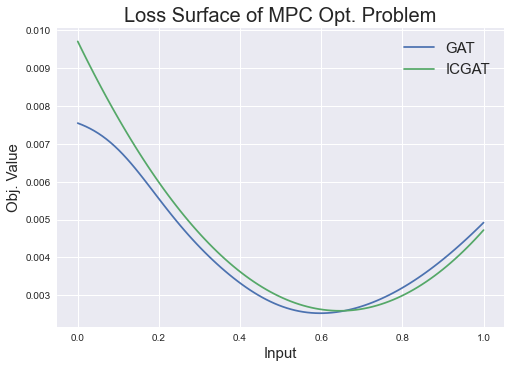

In [56]:
for model_name in model_names:
    saved_model_path = 'saved_model/{}_{}.pt'.format(model_name, data_ratio)
    model = get_model(model_name, hidden_dim, is_convex, saved_model_path).to(DEVICE)
    target_y = 0.1 * torch.ones((num_sensors, 1, 1)).to(DEVICE)
    loss_list = measure_loss(model, graph, target_y, receding_history, num_sensors, num_heaters, num_divides)
    plt.plot(np.linspace(0, 1, 100), loss_list, label='{}'.format(model_name))
plt.legend(fontsize=15)
plt.xlabel('Input', size=15)
plt.ylabel('Obj. Value', size=15)
# plt.ylim([0.0, 0.002])
plt.title('Loss Surface of MPC Opt. Problem', size=20)
plt.show()